<a href="https://colab.research.google.com/github/DonaldTurton/AT2_Advanced_Data_Algorithms/blob/master/XGB_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# XGB

In [0]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Data Visualization
import seaborn as sns #Correlation plot
from google.colab import files

# Libraries for XGBOOST
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [237]:
url = 'https://raw.githubusercontent.com/DonaldTurton/AT2_Advanced_Data_Algorithms/master/adaa_data.csv'
data = pd.read_csv(url)
data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index
0,2018,1,1,6912.25,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,0.000,0.0000,0.000,0.000,1,1,Monday,2,1
1,2018,1,1,6745.63,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,0.0000,NaN,0.000,1,1,Monday,3,2
2,2018,1,1,6466.06,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,0.0000,6828.940,0.000,1,1,Monday,4,3
3,2018,1,1,6279.80,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,81.4500,6605.845,6600.935,1,1,Monday,5,4
4,2018,1,1,6177.31,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,75.8025,6372.930,6417.200,1,1,Monday,6,5


In [238]:
# LAG Total Demand by 30 mins 
data['TOTALDEMAND'] = data['TOTALDEMAND'].shift(1)
data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index
0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,0.000,0.0000,0.000,0.000,1,1,Monday,2,1
1,2018,1,1,6912.25,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,0.0000,NaN,0.000,1,1,Monday,3,2
2,2018,1,1,6745.63,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,0.0000,6828.940,0.000,1,1,Monday,4,3
3,2018,1,1,6466.06,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,81.4500,6605.845,6600.935,1,1,Monday,5,4
4,2018,1,1,6279.80,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,75.8025,6372.930,6417.200,1,1,Monday,6,5


In [239]:
# Update the moving average variables

data.demand_mov_avg_1hr = data.TOTALDEMAND.rolling(window=2).mean()
data.demand_mov_avg_2hr = data.TOTALDEMAND.rolling(window=4).mean()

data.head()

# Create a new price variable with one unit lag (predicting current price will be influenced by the previous periods price)

data['lagprice'] = data.RRP.shift(1)

data.head()

# Create moving average variables for 1hr and 2hrs in python

data.price_mov_avg_1hr = data.lagprice.rolling(window=2).mean()
data.price_mov_avg_2hr = data.lagprice.rolling(window=4).mean()

data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index,lagprice
0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,2,1,NaN
1,2018,1,1,6912.25,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,3,2,91.86
2,2018,1,1,6745.63,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,NaN,6828.940,NaN,1,1,Monday,4,3,88.83
3,2018,1,1,6466.06,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,NaN,6605.845,NaN,1,1,Monday,5,4,73.62
4,2018,1,1,6279.80,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,81.45,6372.930,6600.935,1,1,Monday,6,5,71.49


In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 22 columns):
Year.x                                  28080 non-null int64
Month                                   28080 non-null int64
Day                                     28080 non-null int64
TOTALDEMAND                             28079 non-null float64
RRP                                     28080 non-null float64
date_keep                               28080 non-null object
time_keep                               28080 non-null object
Daily.global.solar.exposure..MJ.m.m.    28080 non-null float64
Minimum.temperature..Degree.C.          28080 non-null float64
Maximum.temperature..Degree.C.          28080 non-null float64
Rainfall.amount..millimetres.           28080 non-null float64
Season                                  28080 non-null int64
price_mov_avg_1hr                       28078 non-null float64
price_mov_avg_2hr                       28076 non-null float64
demand_mov_avg_1hr 

In [241]:
data.describe()

#MAX PRICE 4631??

,Year.x,Month,Day,TOTALDEMAND,RRP,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,segment_30min,index,lagprice
count,28080.000000,28080.000000,28080.000000,28079.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28078.000000,28076.000000,28078.000000,28076.000000,28080.000000,28080.000000,28080.000000,28080.000000,28079.000000
mean,2018.376104,5.637856,15.545584,8081.261910,84.282953,16.133415,14.858526,23.990242,2.190085,2.331695,84.280454,84.279310,8081.291454,8081.354096,2.458333,22.643839,24.500000,14040.500000,84.281166
std,0.484415,3.223593,8.825677,1236.576367,58.744794,6.895621,5.044146,5.425505,6.981044,1.020859,51.097118,43.801590,1221.583076,1195.382790,1.153969,14.001739,13.853646,8106.142116,58.745077
min,2018.000000,1.000000,1.000000,5552.230000,2.980000,1.700000,4.200000,13.800000,0.000000,1.000000,9.065000,10.130000,5564.420000,5568.900000,1.000000,1.000000,1.000000,1.000000,2.980000
25%,2018.000000,3.000000,8.000000,7187.235000,62.300000,11.100000,10.400000,19.800000,0.000000,1.000000,62.460000,63.100000,7196.916250,7216.433125,1.000000,11.000000,12.750000,7020.750000,62.300000
50%,2018.000000,5.000000,15.000000,7996.030000,74.920000,14.400000,15.300000,23.400000,0.000000,2.000000,75.467500,76.342500,7997.760000,8002.013750,3.000000,21.000000,24.500000,14040.500000,74.920000
75%,2019.000000,8.000000,23.000000,8789.740000,94.802500,20.700000,19.200000,27.900000,0.400000,3.000000,95.033750,95.214375,8786.420000,8774.823125,3.000000,32.000000,36.250000,21060.250000,94.800000
max,2019.000000,12.000000,31.000000,13700.900000,4631.980000,32.100000,23.800000,43.700000,56.600000,4.000000,3478.520000,2372.550000,13669.780000,13583.927500,4.000000,52.000000,48.000000,28080.000000,4631.980000


In [242]:
#Find Null values 
data.isnull().sum()

Year.x                                  0
Month                                   0
Day                                     0
TOTALDEMAND                             1
RRP                                     0
date_keep                               0
time_keep                               0
Daily.global.solar.exposure..MJ.m.m.    0
Minimum.temperature..Degree.C.          0
Maximum.temperature..Degree.C.          0
Rainfall.amount..millimetres.           0
Season                                  0
price_mov_avg_1hr                       2
price_mov_avg_2hr                       4
demand_mov_avg_1hr                      2
demand_mov_avg_2hr                      4
segment_day                             0
week_of_year                            0
day_of_week                             0
segment_30min                           0
index                                   0
lagprice                                1
dtype: int64

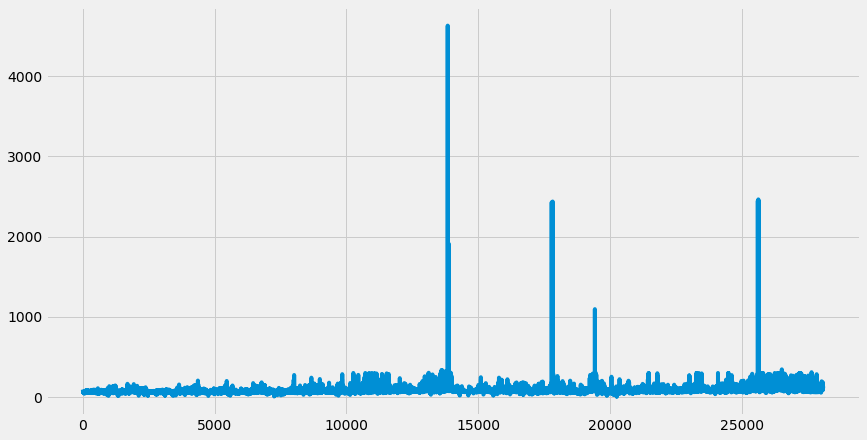

In [253]:
#Plot trend
Price = data["RRP"].values
plt.figure(figsize=(13,7))
plt.plot(Price)
plt.show()

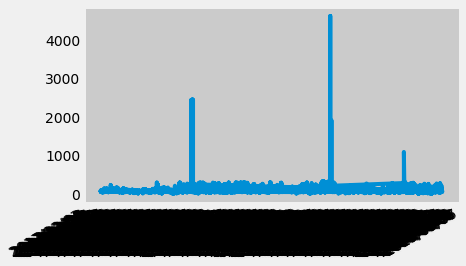

In [270]:
import matplotlib.dates as mdates
import datetime as dt

date = data["date_keep"].values
Date = [dt.datetime.strptime(d,'%Y/%m/%d').date() for d in date]

Price = data["RRP"].values


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(Date,Price)
plt.gcf().autofmt_xdate()
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90) 

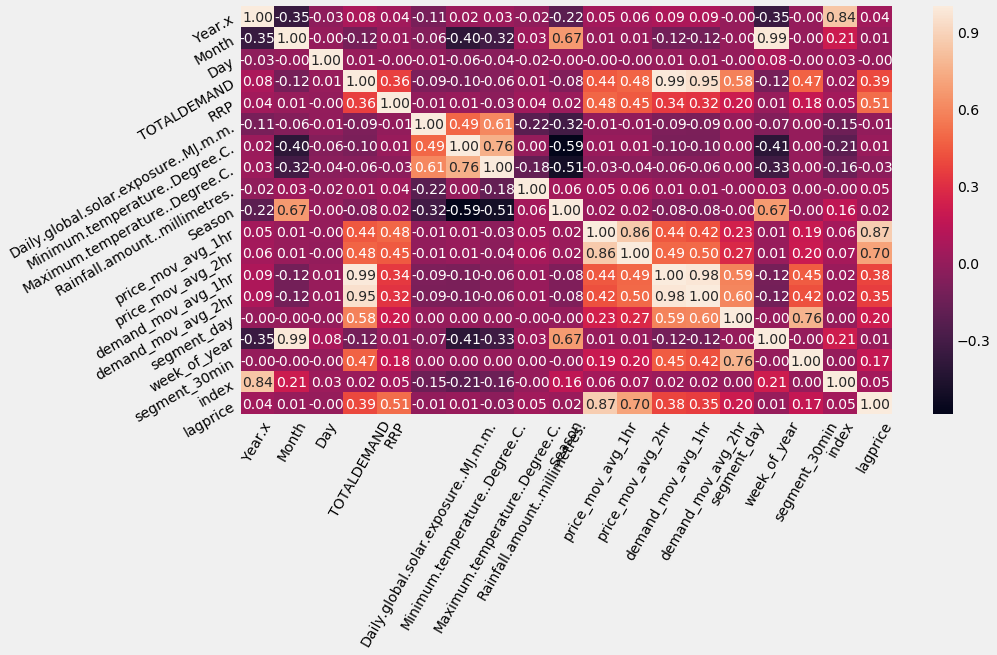

In [271]:
corr = data.corr()
plt.figure(figsize=(13,7))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60) 
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30) 
plt.show()

# XG Boost

## Data Preparation

In [0]:
### ONE HOT-ENCONDING for TYPE OBJECTS 



In [0]:
#Drops Na  NON NA's
#data.dropna(axis=0, subset=['RRP'], inplace=True)

In [272]:
#Chek 
data.isnull().sum()

Year.x                                  0
Month                                   0
Day                                     0
TOTALDEMAND                             1
RRP                                     0
date_keep                               0
time_keep                               0
Daily.global.solar.exposure..MJ.m.m.    0
Minimum.temperature..Degree.C.          0
Maximum.temperature..Degree.C.          0
Rainfall.amount..millimetres.           0
Season                                  0
price_mov_avg_1hr                       2
price_mov_avg_2hr                       4
demand_mov_avg_1hr                      2
demand_mov_avg_2hr                      4
segment_day                             0
week_of_year                            0
day_of_week                             0
segment_30min                           0
index                                   0
lagprice                                1
dtype: int64

## Data Partitioning

In [0]:
# Objective variable selection
y = data.RRP
X = data.drop(['RRP', "date_keep", "time_keep", "index", "Year.x", "day_of_week"], axis=1)

In [0]:
#Prevous partitioning form
#train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.30)

In [0]:
# Data partition
train_X = X[0:19656]
test_X = X[19656:28080]
train_y = y[0:19656]
test_y = y[19656:28080]


In [276]:
#Check data set partitioning 
train_X.shape, train_y.shape

((19656, 16), (19656,))

In [277]:
#Imputer FOR COMPLEATING MISSING VALUES 
my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)




/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Model

In [278]:
# Build model
import xgboost
from xgboost import XGBRegressor

# Run The model
my_model = XGBRegressor()

# Train the model on training data
my_model.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:09:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions
predictions = my_model.predict(test_X)

In [280]:
#MAE
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 18.842795065927824


In [281]:
#RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(predictions,test_y))
print("RMSE: " + str(rmse))

RMSE: 57.94665227289646


In [282]:
# Calculate the RMSE based on formula definition  LIKE IN RF
np.sqrt(((predictions - test_y) ** 2).mean()) 

57.94665227289643

In [283]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
errors = abs(predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #accuracy is 77.03%

Mean Absolute Error: 18.84 degrees.
Accuracy: 82.96 %.


## Hyper Parameter Tunning

### 1


In [285]:
# Early Stoppig Round And Learning rate
XGB_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
XGB_model.fit(train_X, train_y, early_stopping_rounds=50, 
             eval_set=[(test_X, test_y)], verbose=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:20:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions
XGB_prediction = XGB_model.predict(test_X)



In [287]:
XGB_mse = mean_squared_error(XGB_predictions,test_y)
print("Mean Squared Error : " + str( np.sqrt(XGB_mse)))

Mean Squared Error : 52.86469876597505


In [288]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
XGB_errors = abs(XGB_predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(XGB_errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
XGB_mape = 100 * (XGB_errors / test_y)

# Calculate and display accuracy
XGB_accuracy = 100 - np.mean(XGB_mape)
print('Accuracy:', round(XGB_accuracy, 2), '%.')  #85.27

Mean Absolute Error: 16.29 degrees.
Accuracy: 85.27 %.


## Predictions vs Actual Plot

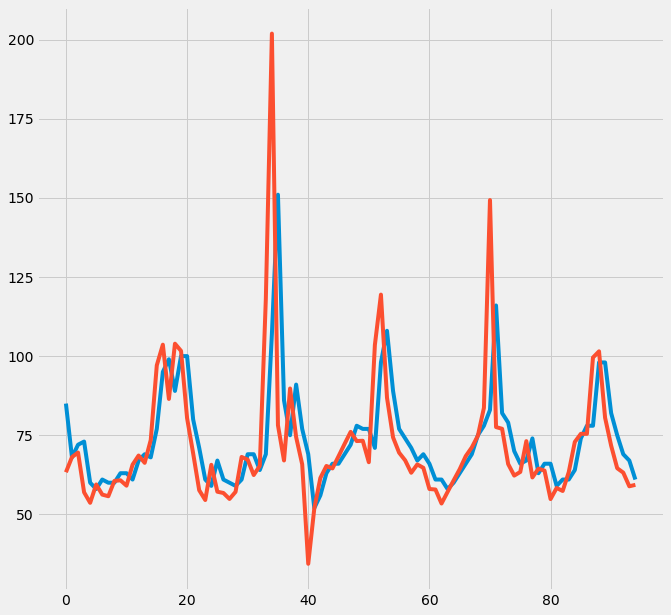

In [289]:
pred_sub = XGB_predictions[1:96]
testy_sub = np.array(test_y[1:96])

#yTest_sub
#pred_sub
plt.plot(pred_sub)
plt.plot(testy_sub)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Feauture Importance

In [290]:
XGB_importances = XGB_model.feature_importances_


# List of tuples with variable and importance
XGB_feature_importances = [(feature, round(XGB_importance, 2)) for feature, XGB_importance in zip(list(X.columns), XGB_importances)]

# Sort the feature importances by most important first
XGB_feature_importances = sorted(XGB_feature_importances, key = lambda X: X[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in XGB_feature_importances]

Variable: lagprice             Importance: 0.25
Variable: Minimum.temperature..Degree.C. Importance: 0.1899999976158142
Variable: price_mov_avg_2hr    Importance: 0.17000000178813934
Variable: price_mov_avg_1hr    Importance: 0.12999999523162842
Variable: TOTALDEMAND          Importance: 0.11999999731779099
Variable: segment_30min        Importance: 0.05000000074505806
Variable: Day                  Importance: 0.019999999552965164
Variable: demand_mov_avg_2hr   Importance: 0.019999999552965164
Variable: Daily.global.solar.exposure..MJ.m.m. Importance: 0.009999999776482582
Variable: Maximum.temperature..Degree.C. Importance: 0.009999999776482582
Variable: Rainfall.amount..millimetres. Importance: 0.009999999776482582
Variable: demand_mov_avg_1hr   Importance: 0.009999999776482582
Variable: segment_day          Importance: 0.009999999776482582
Variable: Month                Importance: 0.0
Variable: Season               Importance: 0.0
Variable: week_of_year         Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Variable Importances')

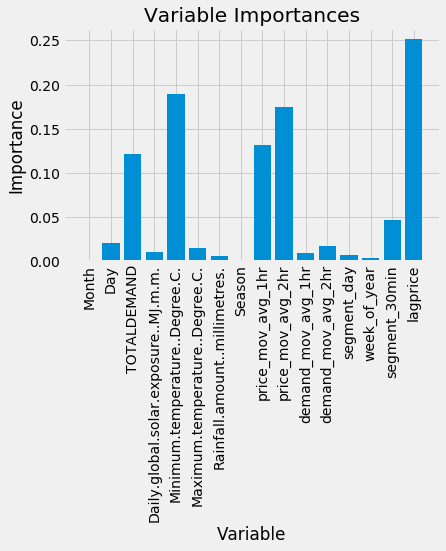

In [291]:
# Graph

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
XGB_x_values = list(range(len(XGB_importances)))

# Make a bar chart
plt.bar(XGB_x_values, XGB_importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(XGB_x_values, list(X.columns), rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

## Cross Validation

In [295]:
# Optimized Data Structure
data_dmatrix = xgboost.DMatrix(data=X,label=y)  ##DOES NOT HANDLE OBJECT

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,6)],  
          'subsample':[i/10.0 for i in range(6,11)],
          'colsample_bytree':[i/10.0 for i in range(6,11)], 
          'max_depth': [2,3,4]}

In [0]:
xgb_CV = XGBRegressor(learning_rate=0.01, n_estimators=1000, objective='reg:squarederror',
                    silent=True, nthread=-1)


In [339]:
grid = GridSearchCV(xgb_CV, params)
grid.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) i

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.01,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1000, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    rand...g_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=True,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'gamma': [0.3, 0.4, 0.5],

In [0]:
# make predictions
xgb_CV_prediction = grid.predict(test_X)

In [345]:
xgb_CV_mse = mean_squared_error(xgb_CV_prediction,test_y)
print("Mean Squared Error : " + str( np.sqrt(xgb_CV_mse)))

Mean Squared Error : 56.384209967163535


In [346]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
xgb_CV_errors = abs(xgb_CV_prediction - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(xgb_CV_errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
xgb_CV_mape = 100 * (xgb_CV_errors / test_y)

# Calculate and display accuracy
xgb_CV_accuracy = 100 - np.mean(xgb_CV_mape)
print('Accuracy:', round(xgb_CV_accuracy, 2), '%.') #accuracy is 82.9%

Mean Absolute Error: 18.49 degrees.
Accuracy: 82.9 %.


#  jv

In [0]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,98.345002,1.536402,97.662944,12.931403
1,94.794072,1.601526,94.169079,13.263547
2,91.437399,1.664891,90.852470,13.546954
3,88.234338,1.694773,87.704221,13.898519
4,85.209795,1.720800,84.694689,14.138841


In [0]:
print((cv_results["test-rmse-mean"]).tail(1))

99    48.601906
Name: test-rmse-mean, dtype: float64


### Results Visualization

In [0]:
#????????? it only prints the naemes if I use this
xgreg = xgboost.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[04:50:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


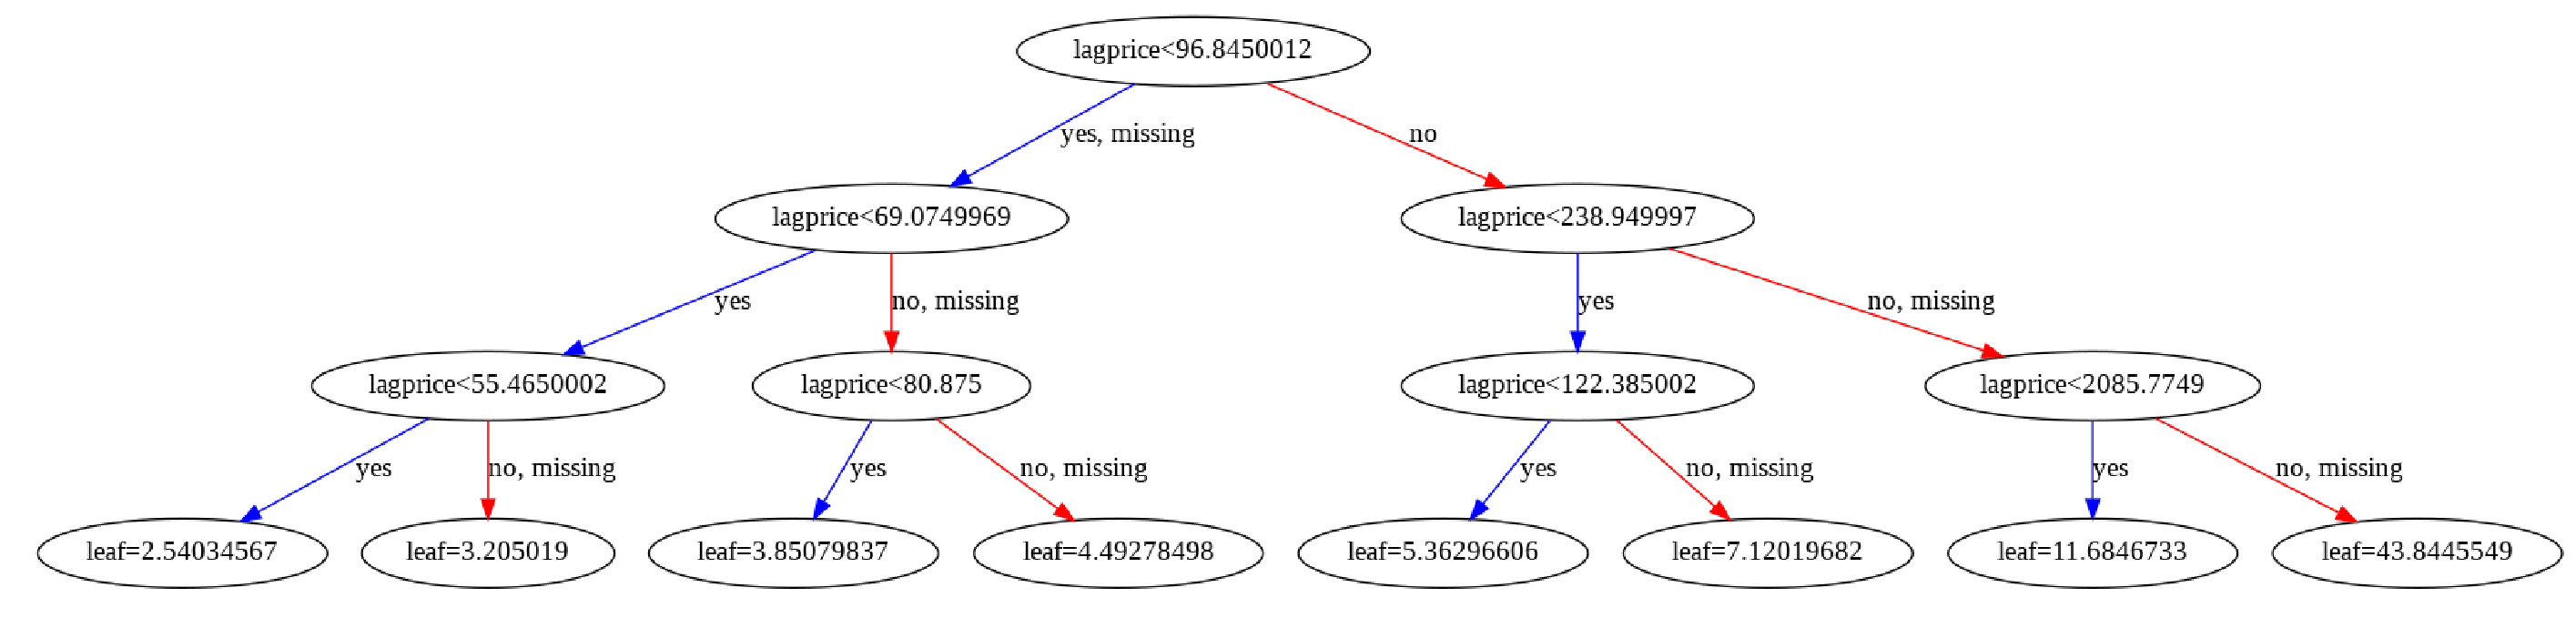

In [0]:
#Plot tree
xgboost.plot_tree(xgreg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 20]
plt.show()

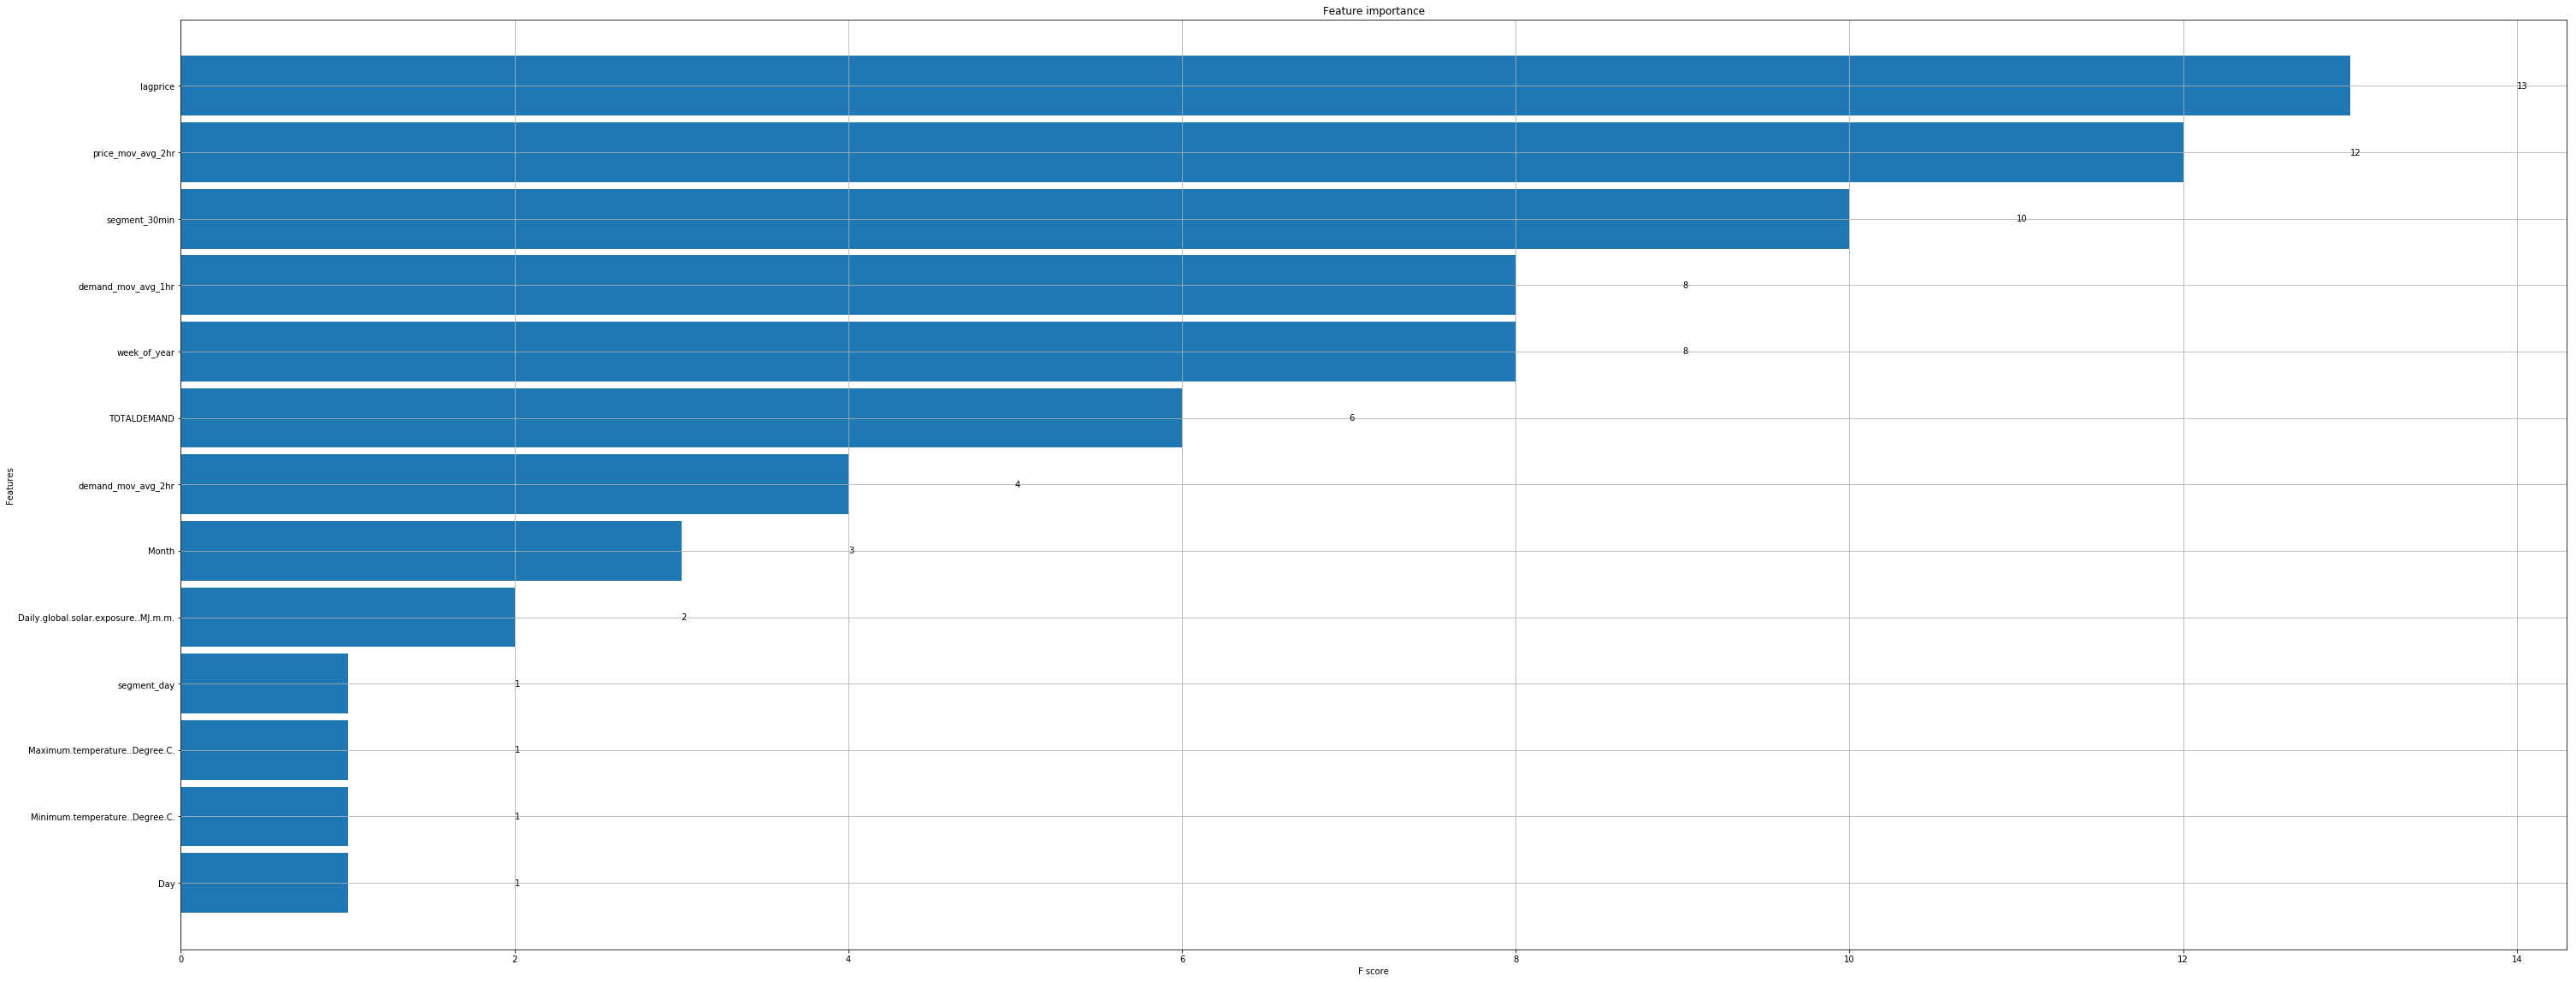

In [0]:
xgboost.plot_importance(xgreg, height=0.9)

In [0]:
##### FOR DECISION TREE

# Change Data Structure #XGB CAN ONLY MANAGE NUMERIC VARIABLES 

data.segment_30min = data.segment_30min.astype('category')

data.day_of_week = data.day_of_week.astype('category')

data.week_of_year = data.week_of_year.astype('category')

data.segment_day = data.segment_day.astype('category')

data.Season = data.Season.astype('category')

data.info()